# Introduction to Music Genre Identifier Neural Network

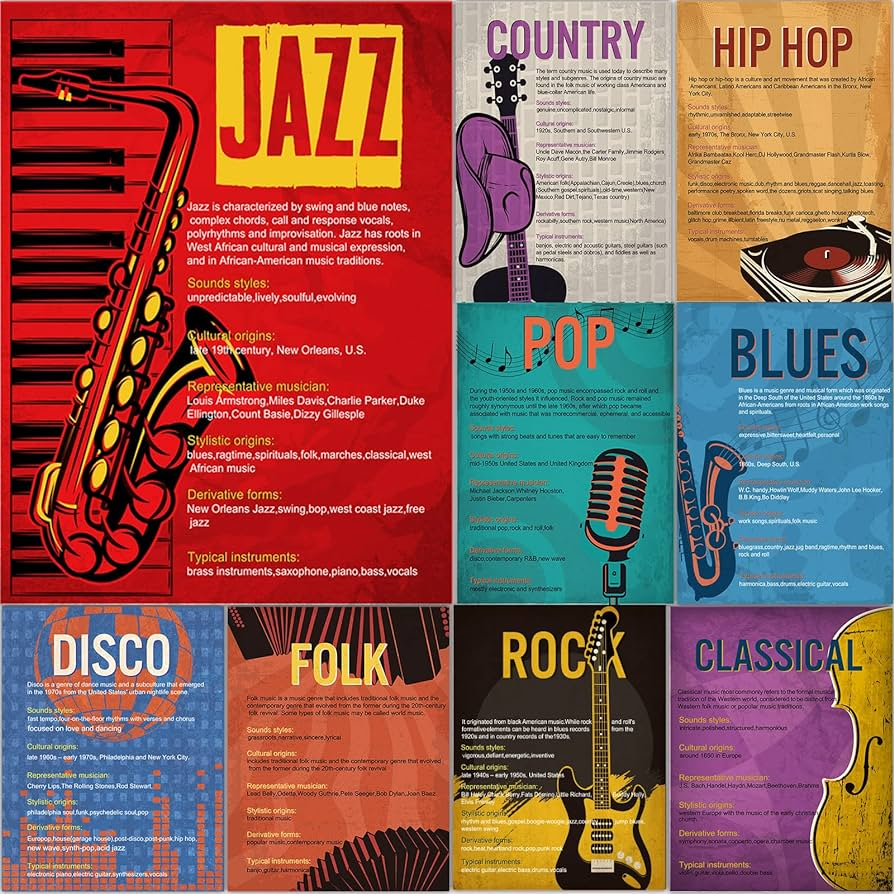

In this project, we will develop a neural network to identify music genres from audio files. We will use a dataset contained in the `fma_small.zip` file, which includes a variety of music tracks labeled with their respective genres. By training our neural network on this dataset, we aim to accurately classify the genre of music tracks. This project will involve data preprocessing, feature extraction, model training, and evaluation to achieve our goal.

The data includes 8 music genres, and 8K tracks of 30 seconds.

The metadata must be downloaded from https://os.unil.cloud.switch.ch/fma/fma_metadata.zip (342 MB)
You may download the songs from 'https://os.unil.cloud.switch.ch/fma/fma_small.zip' (7.2 GB)

In [1]:
# Firstly we must unzip the songs data and metadata
'''
import zipfile
with zipfile.ZipFile('./fma_small.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')
with zipfile.ZipFile('./fma_metadata.zip', 'r') as zip_ref:
    zip_ref.extractall('./data') '''

"\nimport zipfile\nwith zipfile.ZipFile('./fma_small.zip', 'r') as zip_ref:\n    zip_ref.extractall('./data')\nwith zipfile.ZipFile('./fma_metadata.zip', 'r') as zip_ref:\n    zip_ref.extractall('./data') "

In [2]:
import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils

# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [3]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


In [4]:
small = tracks[tracks['set', 'subset'] <= 'small']
small = small['track']
small = small[:1000]

def get_track_full_name(track_id):
    """
    Obtiene el nombre completo de un track con su id.

    :param track_id: Identificador del track
    :return: String con el identificador completo del track
    """
    return str(track_id).zfill(6)

def get_path(track_id):
    """
    Retorna la ruta de una canción con el track_id

    :param track_id: Identificador del track
    :return: String con la ruta del track
    """
    full_name = get_track_full_name(track_id)
    return f"./data/fma_small/{full_name[:3]}/{full_name}.mp3"

def get_genre(track_id):
    """
    Retorna el género al que pertenece una canción con el track_id

    :param track_id: Identificador del track
    :return: String con el nombre del género de la canción
    """
    return small[track_id].genre_top


## Transformación del audio

Para la utilización del repositorio de datos encontrado es necesario realizar una transformación temporal del archivo a wav

In [5]:
from pydub import AudioSegment
import tempfile
AudioSegment.converter = "C:\\ffmpeg\\bin\\ffmpeg.exe"
AudioSegment.ffmpeg = "C:\\ffmpeg\\bin\\ffmpeg.exe"
AudioSegment.ffprobe ="C:\\ffmpeg\\bin\\ffprobe.exe"

def mp3_to_wav_path(filepath):
    """
    Lee un archivo de audio (MP3 o WAV), lo decodifica y genera su gráfica.
    
    :param filepath: Ruta al archivo de audio (WAV).
    """
    # Obtener el audio mp3 para convertirlo temporalmente a WAV    
    audio = AudioSegment.from_mp3(filepath)
    # Crear un archivo temporal para el WAV
    temp_wav = tempfile.NamedTemporaryFile(suffix=".wav", delete=False)
    audio.export(temp_wav.name, format="wav")
    filepath = temp_wav.name
    return filepath

## Visualización de audio

En este ejemplo, veamos como visualizar un canal de una señal de audio. Para esto, utilizaremos **tf.io.read_file** para cargar a memoria el contenido de un archivo de audio, **tf.audio.decode_wav** para decodificar el contenido del archivo (bytes) e interpretarlo como el contenido de un archivo de audio en formato **wav**. Al decodificar el archivo de audio obtendremos:
- Una o más secuencias de valores escalares (muestras que representan la magnitud o amplitud de la onda). El número de secuencias depende del número de canales utilizados para grabar el audio (por ejemplo, mono, estereo, etc.).
- La frecuencia de muestreo a la cual se grabo el audio.

Una vez que tenemos las secuencias de valores escalares, podemos visualizar la secuencia mediante el uso de **plt.plot**

Analiza y ejeucta la siguiente celda, verifica cuantas secuencias retorna **decode_wav** y la frecuencia de muestre con la que fue grabado el audio.

nota: observa que en este ejemplo se gráfica únicamente la onda sorrespondiente  a un canal.

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def plot_audio(filepath):

  filepath = mp3_to_wav_path(filepath)
  #Cargar el archivo binario
  audio_binary=tf.io.read_file(filepath)

  # Decodificar el contenido del archivo binario
  # Secuencia de escalares (magnitudes) y frecuencia de muestreo
  audio, audioSR = tf.audio.decode_wav(audio_binary)

  # Trabajaremos con un eje (matriz a vector)
  audio = tf.squeeze(audio, axis=-1)

  t = np.arange(0, len(audio))
  plt.plot(t, audio, 'g')
  plt.show()

## Reproducción de audio

Veamos cómo reproducir un archivo de audio utilizando **Audio** y **display** del módulo **display** de **IPython**. Existen diversas librerías que podemos utilizar para la reproducción de audio, te invito a explorar y comparar.

In [7]:
from IPython.display import Audio, display

def play_audio(filepath):

  filepath = mp3_to_wav_path(filepath)
  #Cargar el archivo binario
  audio_binary=tf.io.read_file(filepath)

  # Decodificar el contenido del archivo binario
  # Secuencia de escalares (magnitudes) y frecuencia de muestreo
  audio, audioSR = tf.audio.decode_wav(audio_binary)

  audio = tf.squeeze(audio, axis=-1)

  # Obtenemos una secuencia de valores escalares
  sr = tf.get_static_value(audioSR)

  # Es importante considerar que rate debe ser igual a la frecuencia utilizada en la grabación del audio
  display(Audio(audio, rate=audioSR, autoplay=False))

## Uso de STFT (Short Time Fourier Transform) para obtener los espectros de frecuencia y magnitudes

La transformada de Fourier de tiempo corto (STFT) es una técnica que analiza cómo cambia el contenido de frecuencia de una señal a lo largo del tiempo.

En la siguiente celda, podrás observar cómo podemos crear un espectrograma de la señal de audio utilizando STFT. Esto es, una representación visual que nos permite tener información sobre las frecuencias en el tiempo y la magnitud de la onda como color en una imagen.

In [8]:
import tensorflow as tf
import numpy as np

def audioToTensor(filepath):

  filepath = mp3_to_wav_path(filepath)
  #print(filepath)
  
  #Cargar el archivo binario
  audio_binary=tf.io.read_file(filepath)

  # Decodificar el contenido del archivo binario
  # Secuencia de escalares (magnitudes) y frecuencia de muestreo
  audio, audioSR = tf.audio.decode_wav(audio_binary, desired_channels = 1)
  #print(audioSR)
  #print(f"Audio shape before squeeze: {audio.shape}")

  audio = tf.squeeze(audio, axis=-1)
  #print(f"Audio shape after squeeze: {audio.shape}")

  sr = tf.get_static_value(audioSR)

  # Longitud máxima de las secuencias de entrada
  # si sample rate = 16000, la logitus máxima sería: 16000*4 (audioSR * seg_len_max)
  # 4 segundos de datos

  seg_len_max=30
  if len(audio) <  audioSR*seg_len_max:
    #Apliquemos un padding
    audio = tf.concat([np.zeros([int(audioSR*seg_len_max)-len(audio)]), audio], 0)
  else:
    #Trunquemos la secuencia de datos acorde a la longitud máxima
    audio = audio[-int(audioSR*seg_len_max):]

  #frame_length nos permite definir el tamaño de la venta
  #frame_step nos permite indicar el número de desplazamientos dela venta
  spectro = tf.signal.stft(audio, frame_length=512, frame_step=128)  #Genera el espectrograma (nuestra secuencia de entrada al modelo)
  spectro = tf.abs(spectro)
  return spectro

In [9]:
s = audioToTensor('./data/fma_small/000/000002.mp3')

## Visualizar el espectograma

In [10]:
def plot_spectrogram(spectrogram):
  h = spectrogram.shape[0]
  w = spectrogram.shape[1]
  spec_log = np.log(tf.transpose(spectrogram) + np.finfo(float).eps)
  plt.xlabel("Tiempo")
  plt.ylabel("Frecuencia")
  plt.pcolormesh(range(h), range(w), spec_log)
  plt.show()

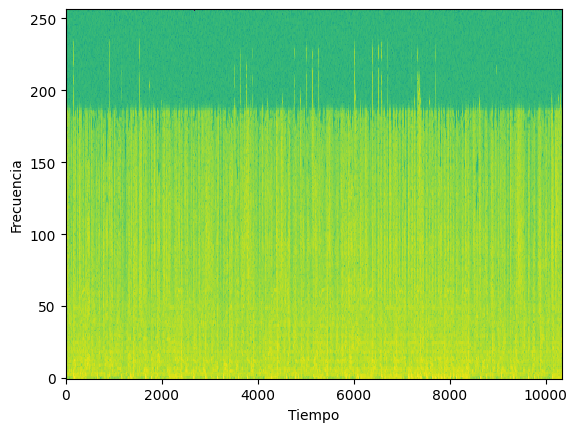

tf.Tensor(
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.52420521e+00 4.70163107e+00 7.66301537e+00 ... 4.71038111e-05
  1.06805666e-04 1.56879425e-04]
 [6.94152546e+00 7.94061041e+00 1.03138342e+01 ... 5.69056756e-05
  1.19609162e-04 2.24351883e-04]
 [5.66083574e+00 6.90069914e+00 6.09727573e+00 ... 2.98737632e-05
  1.41244644e-04 2.07424164e-04]], shape=(10332, 257), dtype=float32)


In [11]:
plot_spectrogram(s)
print(s)

## Crear generador de datos

Es momento de crear el generador de datos, analicemos la siguiente celda y verifiquemos el shape de los tensores: X, Y.

In [12]:
genres = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 
              'Rock', 'International', 'Electronic', 'Instrumental']

def genre_to_vector(genre):
    # Lista de géneros en orden
    
    # Crear un vector binario inicializado en 0
    vector = [0] * len(genres)
    
    # Buscar el índice del género en la lista y encender el valor correspondiente
    if genre in genres:
        vector[genres.index(genre)] = 1
    
    return vector

# [0, 1, 0, 0, 0, 0, 0, 0]

def getExamples():
    X_audio = []
    Y_genre = []

    for track in small.itertuples(index=True):
        track_path = get_path(track.Index)
        track_genre = track.genre_top
        genre_vector = genre_to_vector(track_genre)
        X_audio.append(audioToTensor(track_path))
        Y_genre.append(genre_vector)
    
    return X_audio, Y_genre

In [13]:
X_audio, Y_command = getExamples()
#print(X_audio.shape, Y_command.shape)

In [14]:
print(X_audio[0]) 

tf.Tensor(
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.52420521e+00 4.70163107e+00 7.66301537e+00 ... 4.71038111e-05
  1.06805666e-04 1.56879425e-04]
 [6.94152546e+00 7.94061041e+00 1.03138342e+01 ... 5.69056756e-05
  1.19609162e-04 2.24351883e-04]
 [5.66083574e+00 6.90069914e+00 6.09727573e+00 ... 2.98737632e-05
  1.41244644e-04 2.07424164e-04]], shape=(10332, 257), dtype=float32)


## Construcción del modelo

In [57]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

num_classes = len(genres)

# 1. First check current data shape and format
print("Original shape:", X_audio[0].shape)  # (10332, 257)

# 2. Format data based on our specific case:
model = Sequential([
    # Input shape should be (timesteps, features)
    # In our case: 10332 timesteps, 257 features
    LSTM(64, input_shape=(10332, 257)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# 3. Prepare data splits
X_train, X_test, y_train, y_test = train_test_split(
    X_audio, 
    Y_command,
    test_size=0.2,
    random_state=42
)

Original shape: (10332, 257)


c:\Users\Alex Casillas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
# Train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# Convert X_audio list to numpy array with padding
# Get max length
max_length = max(x.shape[0] for x in X_audio)
n_features = X_audio[0].shape[1]

# Create padded array
X_padded = np.zeros((len(X_audio), max_length, n_features))
for i, x in enumerate(X_audio):
    # Pad or truncate sequence
    curr_len = x.shape[0]
    if curr_len > max_length:
        X_padded[i] = x[:max_length]
    else:
        X_padded[i, :curr_len] = x

# Convert labels to numpy array 
y = np.array(Y_command)

# 3. Prepare data splits
X_train, X_test, y_train, y_test = train_test_split(
    X_audio, 
    Y_command,
    test_size=0.2,
    random_state=42
)

In [61]:
# Print shapes to pre split
print("Original shapes:")

print(f"X_audio: {len(X_audio)} samples")
print(f"Y_command: {len(Y_command)} samples")

print(X_audio[0].shape)
print(X_audio[1].shape)

# Print shapes to verify split
print("Training shapes:")
print(f"X_train: {len(X_train)} samples")
print(f"y_train: {len(y_train)} samples")
print("\nValidation shapes:")
print(f"X_val: {len(X_test)} samples")
print(f"y_val: {len(y_test)} samples")

print(X_train[0].shape)
print(X_train[1].shape)

# Print class distribution
print("\nClass distribution in training:")
print(pd.Series(y_train).value_counts())
print("\nClass distribution in validation:")
print(pd.Series(y_test).value_counts())

Original shapes:
X_audio: 1000 samples
Y_command: 1000 samples
(10332, 257)
(10332, 257)
Training shapes:
X_train: 800 samples
y_train: 800 samples

Validation shapes:
X_val: 200 samples
y_val: 200 samples
(10332, 257)
(10332, 257)

Class distribution in training:
[0, 0, 1, 0, 0, 0, 0, 0]    171
[0, 0, 0, 0, 0, 1, 0, 0]    150
[1, 0, 0, 0, 0, 0, 0, 0]    115
[0, 0, 0, 0, 1, 0, 0, 0]    110
[0, 0, 0, 1, 0, 0, 0, 0]     94
[0, 1, 0, 0, 0, 0, 0, 0]     91
[0, 0, 0, 0, 0, 0, 1, 0]     41
[0, 0, 0, 0, 0, 0, 0, 1]     28
Name: count, dtype: int64

Class distribution in validation:
[0, 0, 0, 0, 0, 1, 0, 0]    40
[1, 0, 0, 0, 0, 0, 0, 0]    37
[0, 1, 0, 0, 0, 0, 0, 0]    33
[0, 0, 0, 1, 0, 0, 0, 0]    30
[0, 0, 1, 0, 0, 0, 0, 0]    28
[0, 0, 0, 0, 1, 0, 0, 0]    22
[0, 0, 0, 0, 0, 0, 1, 0]     7
[0, 0, 0, 0, 0, 0, 0, 1]     3
Name: count, dtype: int64


In [41]:
# Convert data to TensorFlow Dataset
def create_dataset(X, y, batch_size=32):
    # Convert lists of arrays to a padded tensor
    X_padded = tf.keras.preprocessing.sequence.pad_sequences(
        X, 
        padding='post',
        dtype='float32'
    )
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((X_padded, y))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create training and validation datasets
train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_test, y_test)


In [62]:
# Train the model using datasets
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3
        )])
   

print("X shape:", X_padded.shape)
print("y shape:", y.shape)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.1856 - loss: 2.0782 - val_accuracy: 0.1400 - val_loss: 2.0324
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.2155 - loss: 1.9807 - val_accuracy: 0.1400 - val_loss: 1.9807
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.2232 - loss: 1.9677 - val_accuracy: 0.1400 - val_loss: 1.9674
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.2232 - loss: 1.9612 - val_accuracy: 0.1450 - val_loss: 1.9680
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.2232 - loss: 1.9594 - val_accuracy: 0.1450 - val_loss: 1.9669
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.2232 - loss: 1.9573 - val_accuracy: 0.1450 - val_loss: 1.9672
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.2232 - loss: 1.9553 - val_accuracy: 0.1450 - val_loss: 1.9646
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.2232 - loss: 1.9538 - val_accuracy: 0.1450 - val_loss:

In [64]:
# Evaluate the model

# 1. Find common length (use smallest to avoid memory issues)
min_length = min(x.shape[0] for x in X_test)

# 2. Truncate/pad test data
X_test_processed = np.array([x[:min_length] for x in X_test])

# 3. Make predictions with processed data
y_pred = model.predict(X_test_processed)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix

# 4. Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Optional: Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step
Confusion Matrix:
[[ 0 12  1 17  7  0  0  0]
 [ 0 14  1 13  5  0  0  0]
 [ 0  5  6 14  3  0  0  0]
 [ 0 12  2 12  4  0  0  0]
 [ 0  8  0  7  6  0  0  1]
 [ 0 13  5 13  9  0  0  0]
 [ 0  2  0  2  3  0  0  0]
 [ 0  2  0  1  0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.21      0.42      0.28        33
           2       0.40      0.21      0.28        28
           3       0.15      0.40      0.22        30
           4       0.16      0.27      0.20        22
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         3

    accuracy                           0.19       200
   macro avg       0.11      0.16      0.12       200
weighted avg       0.13      0.19      0.14       200



c:\Users\Alex Casillas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alex Casillas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alex Casillas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [65]:
# Save the model
model.save('music_genre_classifier_3.keras')